# Dataprocessing the Pecan dataset using pandas

### Importing libraries!

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import matplotlib.dates as dates

# plots directory
figure_directory= '../../../doc/thesis/figures/'
# change so that all figures have font size defulat as 22
plt.rcParams.update({'font.size': 18})
# figure size always the same
plt.figure(figsize=(16,12))

### There is also another helpful command:   shift - tab, to show the functions that you can use within the function

In [2]:
# %load pandasreader.py
#!/usr/bin/env python

import os
import sys
import pandas as pd
from collections import defaultdict
from StringIO import StringIO
#################################################################
class Reader():

    def __init__(self,dataset):
        self.dataset = dataset

    def dataSetToFile(self):

        def find(name, path):
            for root, dirs, files in os.walk(path):
                print root,dirs,files
                if name in files:
                    return os.path.join(root, name)
                else:
                    print 'Could not find the dataset %s' %self.dataset
                    sys.exit("Error message")

        self.dataset += '.csv'

        return find(self.dataset, '../../../res/datasets')

    #################################################################
    # to preProcess inputData into how many appliances

    # training for each individual source in the household
    # regularization parameter penalty,
    # gradient step size alpha
    # convergence rate, conv
    def dataParser(self):#, timeScale, numberAppliances):
        datasets = {'weekdayspecanhour2014','weekendpecanhour2014','pecanminute2014','pecanhour2014','testhouses2012','energimynd','cleanpecanhour2014'}

        appliances = defaultdict(dict)
        if type(self.dataset) != str:
#        if type(dataSet) != str:
            print 'Dataset needs to be in string format'
            sys.exit("Error message")

        if self.dataset in datasets:
            readfile = self.dataSetToFile()
            f = open(readfile,'rb')
            if readfile == 'testhouses2012.csv':
                df = pd.read_csv(f,index_col=[0],sep='|',usecols=[0,1,2,3,4,21,22,26,31,41],header=0)
            elif readfile == 'pecanhour2014.csv':
                df = pd.read_csv(f,index_col=[0],sep='|',header=0,na_values=['g'])
            else:
                df = pd.read_csv(f,index_col=[0],sep=';',header=0,na_values=['g'])
        else:
            sys.exit("Could not read the data")
#        return houses, appliances, timeScale, gradientStep        
        return df

    #################################################################
    def format_data(self,df,other=None):
        '''
        Parameters: df dataframe of the apppliacnes
        Return: X^T x m
        '''
        def add_other(df):
            '''
            assuming there is only localhour and use that does not need to
            be treated
            '''
            non_appliances = []
            non_appliances.append(df.columns.tolist().index('localhour'))
            non_appliances.append(df.columns.tolist().index('use'))
            list_appliances = [i for j, i in enumerate(df.columns.tolist()) if j not in non_appliances]
            appliances_sum = df[list_appliances].sum(axis=1)
            return df['use'].subtract(appliances_sum)

        if other != None:
            df['other'] = add_other(df)

        unique = pd.unique(df.index.values.ravel())
        # find the houses with the whole year data
        full_year = map(lambda x: df[df.index==x].shape[0],unique.tolist())
        indices = [i for i, x in enumerate(full_year) if x == 8760]
        best_indices = map(lambda x: unique[x],indices)
        
        d = {}
        for appliance in df.columns.tolist():
            started = 0
            for i in best_indices:
                
                if started == 0:
                    
                    d[str(appliance)] = df[[str(appliance)]][df[str(appliance)].index == i]
                    started = 1
                    dfindex = d[str(appliance)].index
                else:
        
                    d[str(appliance)][str(i)] = pd.Series(df[str(appliance)][df[str(appliance)].index == i].values,index=dfindex)
            
           
            d[str(appliance)]=d[str(appliance)].rename(columns = {str(appliance):str(dfindex[0])})
            d[str(appliance)].reset_index(drop=True, inplace=True)
        return d
        
    
    def split(self,d,portion,timeframe, portion_houses=None, option=None):
        '''
        Parameters: d = dictionary, portion 0.5 - 0.9, timeframe 1-8760
        
        Return: x_train,x_test dictionarys containing dataframes of all the appliances within the timeframe.
        '''
       
        if portion > 0.9:
                print 'holy shit thats a high value of portion, %s' %(portion)
        x_train = {}
        x_test = {}
        timeframe = range(timeframe)
        key = d.keys()[0]
        columns = d[key].columns.tolist()
        train_list  = timeframe[int(len(timeframe) * 0.0):int(len(timeframe) * portion)]
        test_list = timeframe[int(len(timeframe) * portion):int(len(timeframe) * 1.0)]
        '''
        start_day_2014 = 3 # thursday
        if option == 'week':
            for key in d.keys():
                x_train[key] = d[key].loc
        '''
        if portion_houses != None:
            houses  = columns[int(len(columns) * 0.0): int(len(columns) * portion_houses)]
            
        for key in d.keys():
        
            if portion_houses != None:
                x_train[key] = d[key].loc[train_list,houses]
                x_test[key] = d[key].loc[test_list,houses]
            else:
                x_train[key] = d[key].loc[train_list,:]
                x_test[key] = d[key].loc[test_list,:]
                
        return x_train,x_test


In [20]:
# takes about 4 min
dataset = 'pecanhour2014'
reader = Reader(dataset)
df = reader.dataParser() #returning a datafile pandasObject

../../../res/datasets ['Energimyndighet data'] ['.DS_Store', '.testhouses2012.csv.swp', 'cleanpecanhour2014.csv', 'db.sql', 'Energimyndighet data.zip', 'grepScript.sh', 'interpecanhour2014.csv', 'minutes2014.sql', 'partpecan2014.csv', 'partpecan2014.csv.tar.gz', 'partpecan2014.csv.zip', 'pecan_minute_01_01_2014.csv', 'pecanhour2014.csv', 'weekdayspecanhour2014.csv', 'weekendpecanhour2014.csv']


# "Cleaning" the data

In [4]:
df.columns

Index([u'localhour', u'use', u'air1', u'dishwasher1', u'disposal1', u'furnace1', u'grid', u'kitchen1', u'livingroom1', u'range1', u'refrigerator1'], dtype='object')

In [ ]:
#catching negative values
df.loc[(df['use'] < 0) & (df['grid'] < 0)]

## Interpolating the data

### We only take the columns with atleast 80% values, interpolate and set negative values as positive

In [4]:
#method : {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’,
#        ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’ ‘piecewise_polynomial’, ‘pchip’}
appliances = ['localhour', 'use','air1','dishwasher1','refrigerator1','furnace1']
df1 = df[appliances]
df1 = df1.interpolate('nearest')

In [5]:
df_i = df1.copy()
# replace negative values
df_i[df_i.columns[df_i.dtypes != np.object]] = df_i[df_i.columns[df_i.dtypes != np.object]].abs()
df_i['refrigerator1'] = df_i['refrigerator1'].fillna(method='pad')

In [8]:
df1.describe()

,use,air1,dishwasher1,refrigerator1,furnace1
count,4883287.000000,4883287.000000,4883287.000000,4874527.000000,4883287.000000
mean,1.166657,0.273622,0.012837,0.071798,0.126273
std,1.438944,0.586877,0.075471,0.083340,0.320071
min,-2.304717,0.000000,0.000000,0.000000,0.000000
25%,0.341667,0.000000,0.000000,0.039650,0.007000
50%,0.678883,0.000050,0.000000,0.059467,0.025833
75%,1.432150,0.257450,0.000000,0.089533,0.147700
max,32.620050,16.029000,8.354000,44.454000,12.317033


In [25]:
df_i.columns

Index([u'localhour', u'use', u'air1', u'dishwasher1', u'refrigerator1', u'furnace1'], dtype='object')

In [9]:
df_i.describe()

,use,air1,dishwasher1,refrigerator1,furnace1
count,4883287.000000,4883287.000000,4883287.000000,4883287.000000,4883287.000000
mean,1.166775,0.273622,0.012837,0.071730,0.126273
std,1.438848,0.586877,0.075471,0.083280,0.320071
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.341717,0.000000,0.000000,0.039483,0.007000
50%,0.678950,0.000050,0.000000,0.059450,0.025833
75%,1.432233,0.257450,0.000000,0.089533,0.147700
max,32.620050,16.029000,8.354000,44.454000,12.317033


In [10]:
file_name = 'interpecanhour2014'
df_i.to_csv(file_name,sep=';',encoding='utf8')

In [83]:
#dataset = 'testhouses2012'
# takes about 4 min
dataset = 'interpecanhour2014'
reader = Reader(dataset)
df = reader.dataParser() #returning a datafile pandasObject

SystemExit: Error message

Dataset interpecanhour2014 does not exist in the database


To exit: use 'exit', 'quit', or Ctrl-D.


## Find the indices which corresponds to the critera below

In [17]:
# finds the unique values of the houses
unique = pd.unique(df.index.values.ravel())
# find the houses with the whole year data
full_year = map(lambda x: df[df.index==x].shape[0],unique.tolist())
indices = [i for i, x in enumerate(full_year) if x == 8760]
best_indices = map(lambda x: unique[x],indices)

[22 26 48 54 59]


689

## All houses which have a whole year of data

### Saving the dataframe into a file

In [53]:
#to use with excel
file_name = 'cleanpecanhour2014.csv'
df.to_csv(file_name, sep=';', encoding='utf-8')

### Putting it into the postqreSQL

In [ ]:
url = 'http://192.16.145.69/phppgadmin/'

# Splitting data into training and testing between weeks

In [3]:
dataset = 'cleanpecanhour2014'
reader = Reader(dataset)
df = reader.dataParser() #returning a datafile pandasObject

../../../res/datasets ['Energimyndighet data'] ['.DS_Store', '.testhouses2012.csv.swp', 'cleanpecanhour2014.csv', 'db.sql', 'grepScript.sh', 'minutes2014.sql', 'pecanhour2014.csv', 'weekdayspecanhour2014.csv', 'weekendpecanhour2014.csv']


In [15]:
df.describe()

,use,air1,dishwasher1,refrigerator1,furnace1
count,2899560.000000,2899560.000000,2899560.000000,2899560.000000,2899560.000000
mean,1.224401,0.273280,0.011211,0.072381,0.131247
std,1.425997,0.589922,0.071046,0.057320,0.355281
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.360767,0.000000,0.000000,0.040067,0.007017
50%,0.726733,0.000050,0.000000,0.060233,0.022967
75%,1.541300,0.254250,0.000000,0.089250,0.145733
max,27.331050,16.029000,8.354000,1.790367,10.856733


In [26]:
average_use = df['use'].mean()

In [27]:
# find the houses that have below the top usage
df = df.loc[(df['use'] < (4*average_use))]

In [28]:
# finds the unique values of the houses
unique = pd.unique(df.index.values.ravel())
# find the houses with the whole year data
full_year = map(lambda x: df[df.index==x].shape[0],unique.tolist())
indices = [i for i, x in enumerate(full_year) if x == 8760]
best_indices = map(lambda x: unique[x],indices)

In [29]:
df = df.loc[best_indices]

In [30]:
df.describe()

,use,dishwasher1,refrigerator1,furnace1,other
count,508080.000000,508080.000000,508080.000000,508080.000000,508080.000000
mean,0.547548,0.004560,0.056564,0.051786,0.434639
std,0.557337,0.043074,0.044291,0.099992,0.518538
min,0.000000,0.000000,0.000000,0.000000,-3.167867
25%,0.187900,0.000000,0.030850,0.004833,0.113183
50%,0.362700,0.000000,0.047217,0.011033,0.261967
75%,0.691700,0.000000,0.071567,0.051700,0.571117
max,4.655300,0.941533,1.259750,4.026900,4.575350


In [21]:
file_name = 'supercleanpecanhour2014'
df.to_csv(file_name,sep=';',encoding='utf8')

## Formatting the data into correct input using format_data method

In [19]:
df.columns.tolist()

['localhour', 'use', 'air1', 'dishwasher1', 'refrigerator1', 'furnace1']

In [20]:
# returns a dictionary
d = reader.format_data(df,other=True)

## Splitting the dataframes into portions of a month

In [21]:
t = 14

In [22]:
x_train, x_test = reader.split(d,0.5,t)
x_train_use = x_train.pop('use',None)
x_test_use = x_test.pop('use',None)
x_train_localhour = x_train.pop('localhour',None)
x_test_localhour = x_test.pop('localhour',None)

## Splitting into weekdays and weekends

In [33]:
week = pd.DatetimeIndex(pd.to_datetime(df['localhour'])).weekday

In [34]:
weekdays = np.in1d(week.ravel(),range(5)).reshape(week.shape)
weekends = week[np.where(week > 4,week,0)]
weekends = np.in1d(week.ravel(),[5,6]).reshape(week.shape)

In [25]:
len(weekends), len(week)

(2899560, 2899560)

In [35]:
df[weekdays].describe()

,use,air1,dishwasher1,refrigerator1,furnace1
count,2073384.000000,2073384.000000,2073384.000000,2073384.000000,2073384.000000
mean,1.226589,0.275759,0.011213,0.072160,0.134223
std,1.432495,0.592920,0.071486,0.057225,0.361423
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.359683,0.000000,0.000000,0.040017,0.007033
50%,0.727917,0.000050,0.000000,0.059983,0.025000
75%,1.545267,0.261083,0.000000,0.088817,0.150267
max,27.331050,16.029000,8.354000,1.790367,10.856733


In [27]:
df[weekends].describe()

,use,air1,dishwasher1,refrigerator1,furnace1,other
count,826176.000000,826176.000000,826176.000000,826176.000000,826176.000000,826176.000000
mean,1.218911,0.267058,0.011207,0.072935,0.123778,0.743932
std,1.409545,0.582283,0.069929,0.057554,0.339265,1.182183
min,0.000000,0.000000,0.000000,0.000000,0.000000,-6.218700
25%,0.363267,0.000000,0.000000,0.040250,0.007000,0.190283
50%,0.724000,0.000000,0.000000,0.060417,0.019017,0.412933
75%,1.531117,0.236283,0.000000,0.090150,0.137650,0.879200
max,26.437083,8.482233,1.252217,1.046683,9.709983,23.300433


In [37]:
dataset = ['cleanpecanhour2014','weekendpecanhour2014','weekdayspecanhour2014']
file_name = dataset[1]
file_name2 = dataset[2]
df[weekends].to_csv(file_name,sep=';',encoding='utf8')
df[weekdays].to_csv(file_name2,sep=';',encoding='utf8')

# Initial analysis 

In [74]:
local = df['localhour'].tolist()
import datetime, re
xticks = map(lambda x: re.split('\s',x)[0],local)

### Usage for texas is like a poisson distribution, could be used in future research

In [102]:
# get poisson deviated random numbers
np.random.poisson(2, 1000)

array([6, 3, 6, 2, 3, 3, 0, 1, 0, 0, 1, 2, 3, 2, 2, 2, 1, 0, 1, 2, 1, 0, 2,
       0, 1, 2, 3, 4, 1, 1, 4, 6, 4, 2, 2, 1, 2, 2, 1, 2, 1, 1, 4, 4, 3, 3,
       1, 2, 2, 3, 3, 4, 2, 2, 8, 1, 3, 2, 1, 2, 2, 0, 3, 5, 0, 1, 2, 2, 1,
       2, 2, 2, 2, 4, 1, 2, 2, 4, 2, 1, 2, 5, 3, 3, 2, 1, 2, 1, 3, 2, 1, 5,
       3, 3, 1, 1, 0, 2, 1, 2, 1, 2, 2, 0, 3, 3, 4, 4, 0, 3, 2, 3, 4, 1, 2,
       1, 1, 3, 3, 3, 4, 0, 4, 2, 1, 3, 3, 3, 3, 2, 3, 2, 2, 2, 0, 3, 2, 2,
       3, 0, 2, 1, 1, 2, 3, 2, 3, 1, 2, 3, 4, 2, 1, 1, 4, 1, 2, 3, 1, 0, 0,
       3, 1, 2, 0, 1, 3, 2, 3, 1, 0, 1, 1, 3, 2, 1, 3, 6, 2, 0, 1, 2, 2, 1,
       4, 2, 4, 1, 1, 1, 0, 2, 1, 0, 4, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4,
       0, 3, 1, 1, 1, 3, 1, 1, 3, 2, 4, 2, 3, 0, 3, 2, 2, 2, 2, 4, 3, 0, 4,
       1, 3, 1, 1, 2, 0, 0, 4, 2, 0, 0, 3, 2, 1, 0, 3, 0, 3, 1, 3, 2, 3, 2,
       2, 1, 2, 0, 1, 2, 1, 3, 4, 3, 1, 2, 1, 1, 2, 5, 1, 5, 2, 1, 1, 1, 1,
       1, 0, 3, 3, 1, 2, 1, 2, 3, 3, 0, 1, 1, 1, 0, 1, 2, 0, 3, 1, 0, 5, 2,
       1, 2,

In [115]:
df['use'].values.shape

(2899560,)

In [117]:
np.where(df['use'].values[np.where(df['use'].values < 6)] > 6)

(array([], dtype=int64),)

ERROR! Session/line number was not unique in database. History logging moved to new session 132


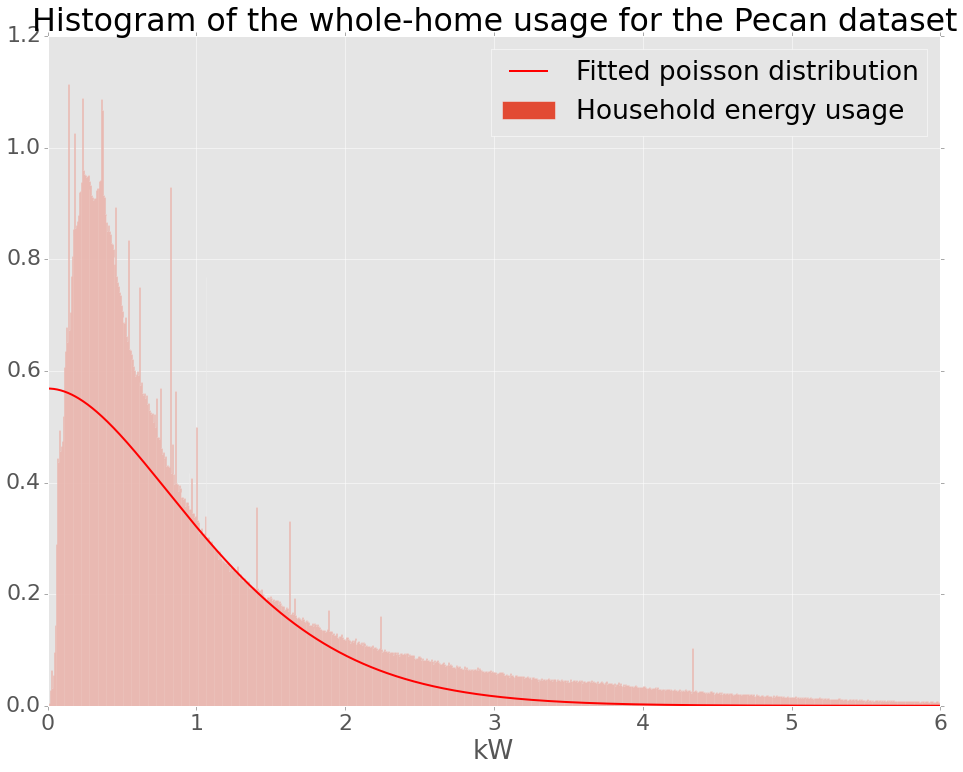

In [170]:
from scipy.optimize import curve_fit
from scipy.misc import factorial
from scipy import stats
plt.figure(figsize=(16,12))

#df_plot = np.where(df['use'].values < 6)
df_plot = df['use'].values[np.where(df['use'].values < 6)]
#entries, bin_edges, patches = df_plot[df_plot < 6].hist(bins=1000, figsize=(16,12),normed=True)
# get poisson deviated random numbers
data = np.random.poisson(2, 1000)
entries, bin_edges, patches = plt.hist(df_plot,bins=1000,normed=True,label='Household energy usage')

# the bins should be of integer width, because poisson is an integer distribution
#entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

(loc, scale) = s.exponweib.fit_loc_scale(data, 1, 1)
print loc, scale

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 6, 1000)

plt.plot(x, weib(x, loc, scale))
plt.hist(data, data.max(), normed=True)
curve = plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2,label='Fitted poisson distribution')

plt.title('Histogram of the whole-home usage for the Pecan dataset')
plt.xlabel('kW')
plt.legend()

plt.savefig(figure_directory+'histusage.png')

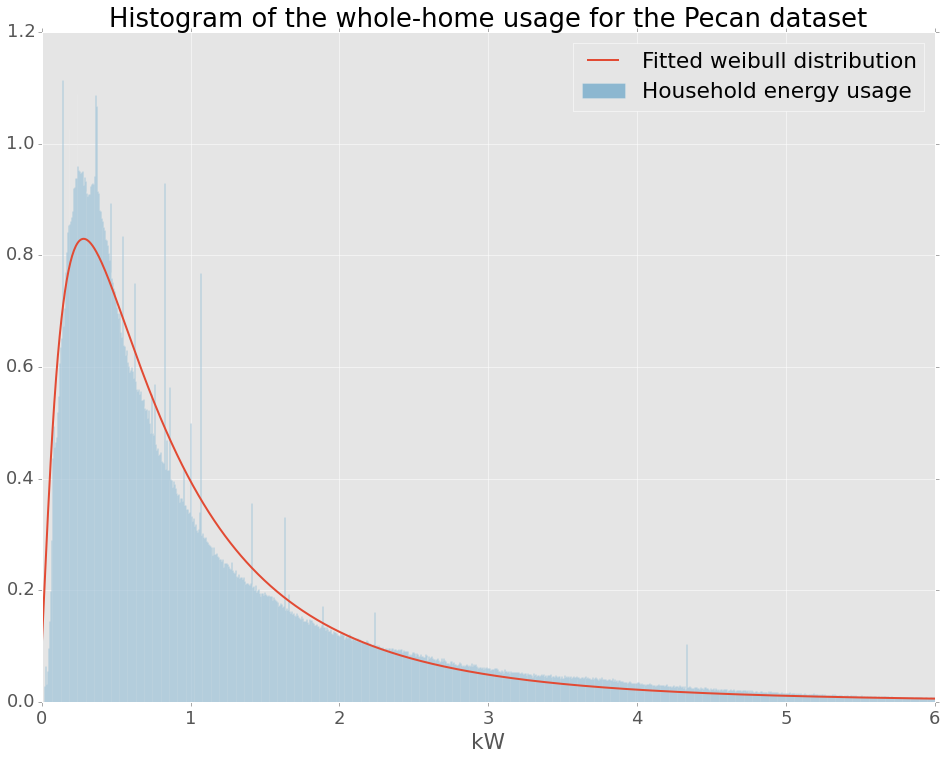

In [9]:
from scipy import stats
plt.figure(figsize=(16,12))
x_plot = np.linspace(0, 6, 1000)
#df_plot = np.where(df['use'].values < 6)
df_plot = df['use'].values[np.where(df['use'].values < 6)]
plt.plot(x_plot, stats.exponweib.pdf(x_plot, *stats.exponweib.fit(df_plot, 1, 1, scale=02, loc=0)),lw=2,label='Fitted weibull distribution')
_ = plt.hist(df_plot, bins=1000, normed=True, alpha=0.5, label='Household energy usage');

plt.title('Histogram of the whole-home usage for the Pecan dataset')
plt.xlabel('kW')
plt.legend()

plt.savefig(figure_directory+'new_histusage.png')

In [60]:
df_test[0:10]

,use,air1,dishwasher1,refrigerator1,furnace1,other
22,0.869367,0.307200,0.000983,0.026017,0.028783,0.506383
22,0.558133,0.000000,0.000000,0.205217,0.009083,0.343833
22,0.226833,0.000000,0.000000,0.125900,0.009433,0.091500
22,0.960367,0.706550,0.000000,0.112067,0.050900,0.090850
22,0.791733,0.614600,0.000183,0.008050,0.111817,0.057083
22,0.730467,0.616283,0.000000,0.000000,0.046417,0.067767
22,0.173783,0.000000,0.000000,0.111117,0.009050,0.053617
22,0.368167,0.297933,0.000000,0.000000,0.026983,0.043250
22,0.785817,0.695600,0.000000,0.000000,0.051283,0.038933
22,0.156983,0.000000,0.000000,0.105900,0.011133,0.039950


In [58]:
df_test = df.copy()
#df[0:100].set_index.plot()

In [59]:
df_test.drop('localhour', axis=1, inplace=True)

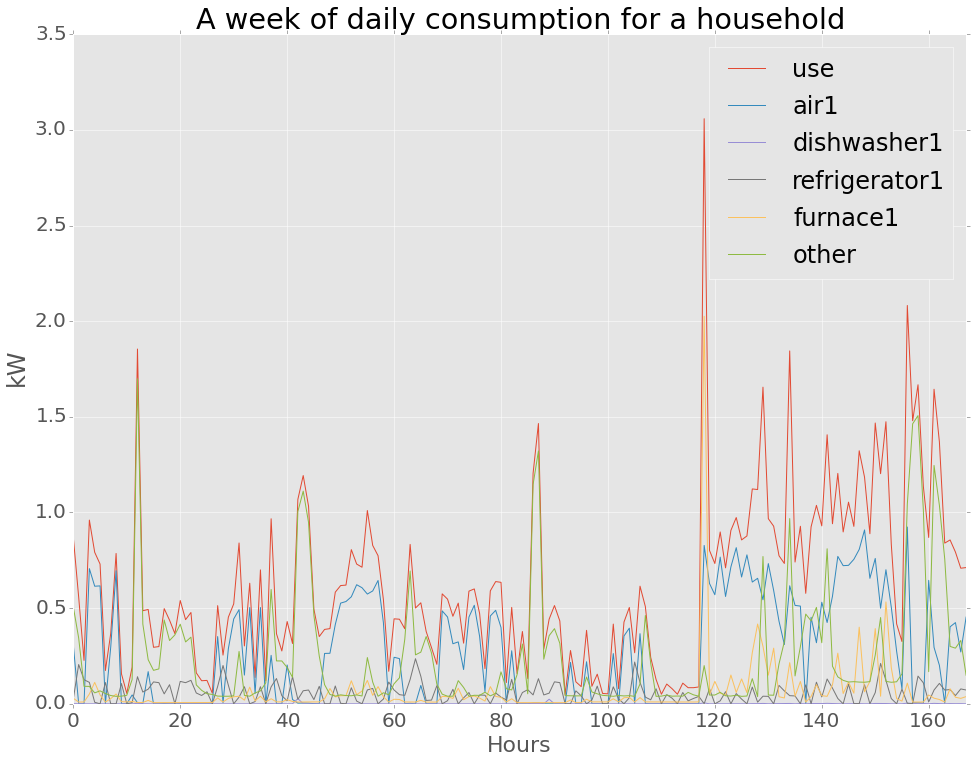

In [172]:
hours = 24*7
df_test[0:hours].reset_index(drop=True).plot(figsize=(16,12))
plt.title('A week of daily consumption for a household')
plt.xlabel('Hour')
plt.ylabel('kW')
figure_directory='../../../doc/thesis/figures/'
plt.savefig(figure_directory+'weekconsump.png')

In [28]:
df_sort =df.set_index(df['localhour']).sort_index(by='localhour')
average_use = map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique())
leng = len(average_use)

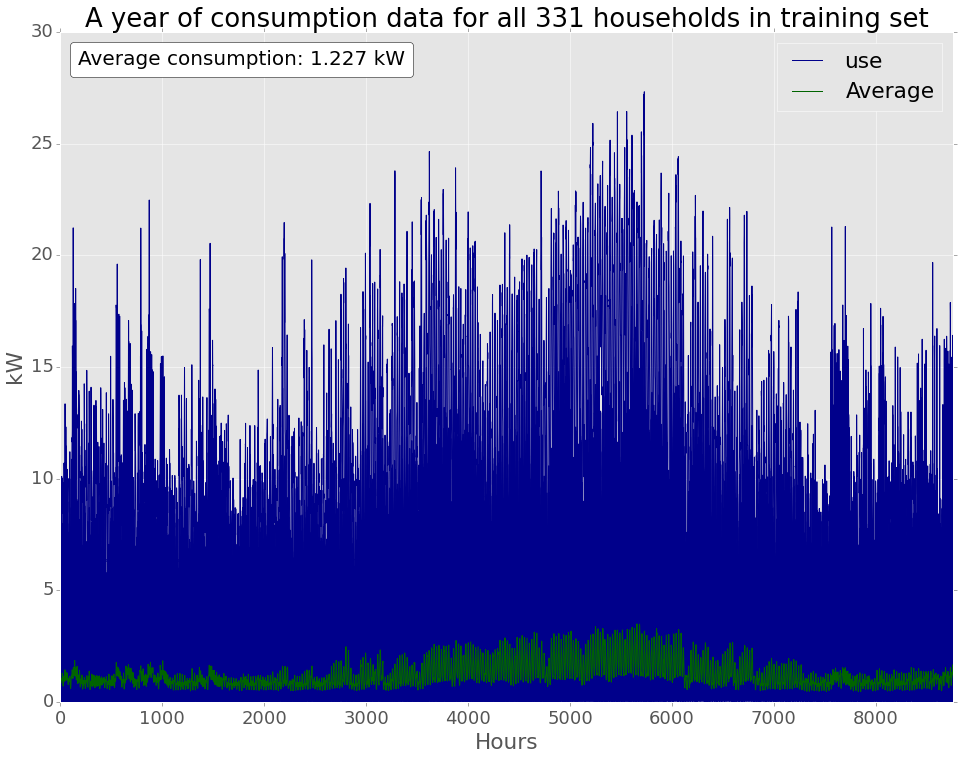

In [29]:
fig, ax = plt.subplots(figsize=(16,12))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', label='Household energy' if i == 0 else '', ax=ax)
    i += 1

s = pd.Series(average_use)
s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='DarkGreen',label='Average Use',lw=1, ax=ax)

plt.title('A year of consumption data for all 331 households in training set')
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: " + str(mean) + " kW",
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

plt.savefig(figure_directory+'houseuse.png')

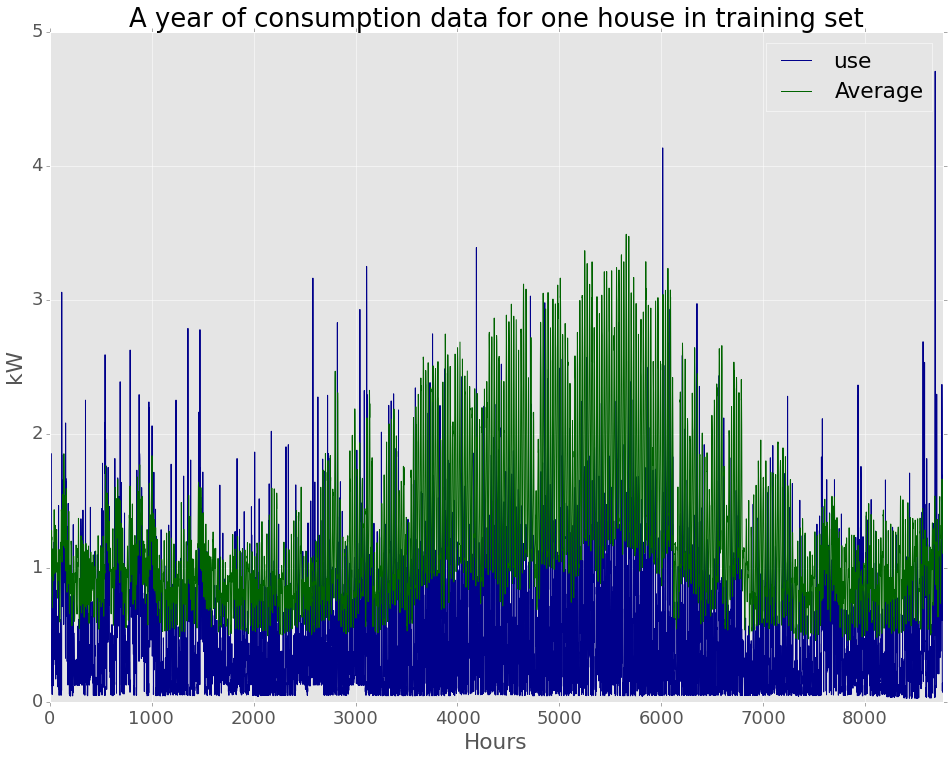

In [255]:
fig, ax = plt.subplots(figsize=(16,12))
houses = df.index.unique()[0:1]
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', label='Household energy' if i == 0 else '', ax=ax)
    i += 1

s = pd.Series(average_use)
s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='DarkGreen',label='Average Use',lw=1, ax=ax)

plt.title('A year of consumption data for one house in training set')
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.savefig(figure_directory+'onehouseuse.png')

In [133]:
idx = pd.date_range('2014-01-01', '2014-12-31',freq='H')

# plotting the weekend household use of the week dataset

In [37]:
dataset = 'weekendpecanhour2014'
reader = Reader(dataset)
df = reader.dataParser() #returning a datafile pandasObject
df_sort =df.set_index(df['localhour']).sort_index(by='localhour')
average_use = map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique())
leng = len(average_use)

../../../res/datasets ['Energimyndighet data'] ['.DS_Store', '.testhouses2012.csv.swp', 'cleanpecanhour2014.csv', 'db.sql', 'Energimyndighet data.zip', 'grepScript.sh', 'interpecanhour2014.csv', 'minutes2014.sql', 'partpecan2014.csv', 'partpecan2014.csv.tar.gz', 'partpecan2014.csv.zip', 'pecan_minute_01_01_2014.csv', 'pecanhour2014.csv', 'weekdayspecanhour2014.csv', 'weekendpecanhour2014.csv']


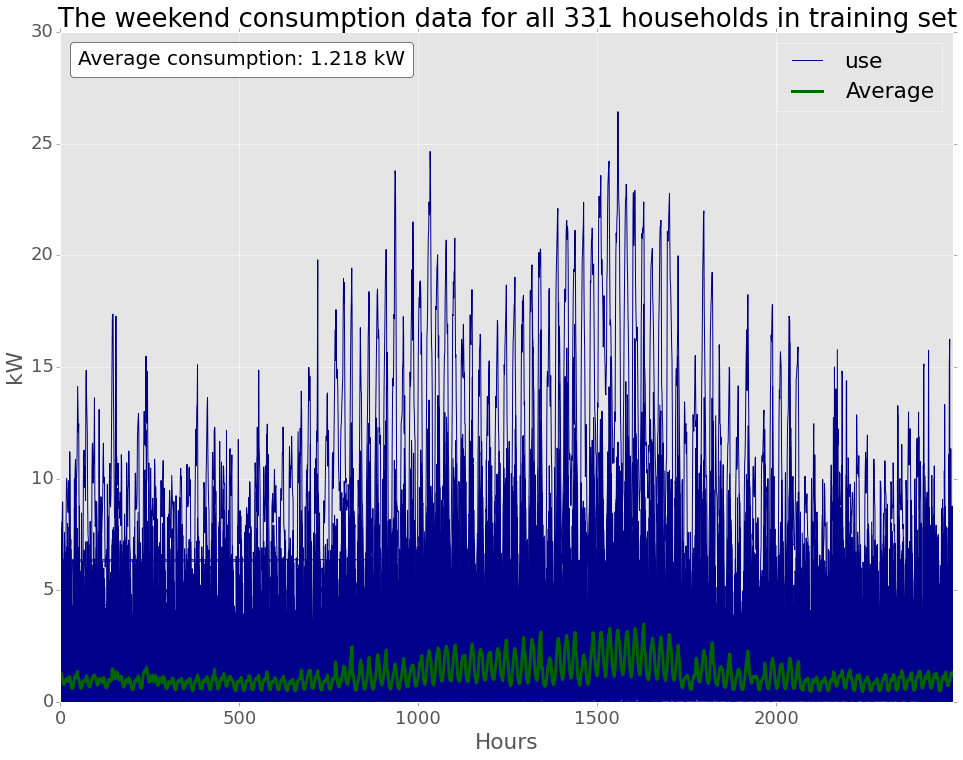

In [38]:
fig, ax = plt.subplots(figsize=(16,12))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', label='Household energy' if i == 0 else '', ax=ax)
    i += 1

s = pd.Series(average_use)
s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='DarkGreen',label='Average Use',lw=3, ax=ax)

plt.title('The weekend consumption data for all 331 households in training set')
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: 1.218 kW",
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

plt.savefig(figure_directory+'weekendhouseuse.png')

## plottting the weekdays of the dataset to be compared with the weekend

In [39]:
dataset = 'weekdayspecanhour2014'
reader = Reader(dataset)
df = reader.dataParser() #returning a datafile pandasObject
df_sort =df.set_index(df['localhour']).sort_index(by='localhour')
average_use = map(lambda x: df_sort.loc[x,'use'].mean(),df_sort.index.unique())
leng = len(average_use)

../../../res/datasets ['Energimyndighet data'] ['.DS_Store', '.testhouses2012.csv.swp', 'cleanpecanhour2014.csv', 'db.sql', 'Energimyndighet data.zip', 'grepScript.sh', 'interpecanhour2014.csv', 'minutes2014.sql', 'partpecan2014.csv', 'partpecan2014.csv.tar.gz', 'partpecan2014.csv.zip', 'pecan_minute_01_01_2014.csv', 'pecanhour2014.csv', 'weekdayspecanhour2014.csv', 'weekendpecanhour2014.csv']


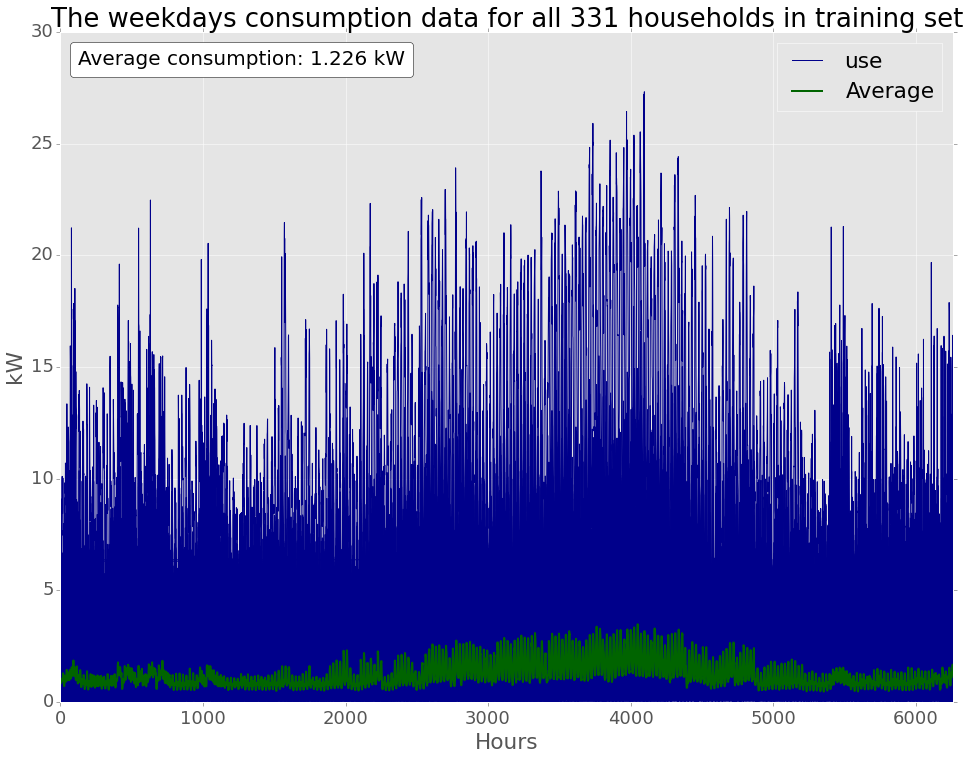

In [40]:
fig, ax = plt.subplots(figsize=(16,12))
houses = df.index.unique()
i = 0
for house in houses:
    df.loc[house,'use'].reset_index(drop=True).plot(color='DarkBlue', label='Household energy' if i == 0 else '', ax=ax)
    i += 1

s = pd.Series(average_use)
mean = round(np.mean(average_use),3)
s_df = pd.DataFrame({'Average':s})
#df_use.set_index()

s_df.plot(color='DarkGreen',label='Average Use',lw=2, ax=ax)

plt.title('The weekdays consumption data for all 331 households in training set')
plt.xlabel('Hours')
plt.ylabel('kW')
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
at = AnchoredText("Average consumption: 1.226 kW",
                  prop=dict(size=20), frameon=True,
                  loc=2,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

plt.savefig(figure_directory+'weekdayshouseuse.png')